In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
import time
import sys
import logging
import uuid
import os
import shutil
import json
import argparse
import pytorch_model_summary as pms
import pyreadr as pyr

from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = ''

CLIP = 1e6

In [ ]:
def load_data(config):
    ''' a function to load the data
        argument:
            config: the configuration file for the run containing the pat to the data source
        returns:
            df_int: uint8 encoded input data
    '''
    logging.info(' loading data from file {}'.format(config['data_dir']))
    
    # input files
    config['data_dir'] = config['data_dir']+'/' if config['data_dir'][-1] != '/' else config['data_dir']
    config['data_fname'] = config['data_dir']+config['cell_line']+ '-'+config['exon_buffer']+'-50-50/regression_'+config['cell_line'] +'_binding_psi_psip_KD.rds'
    config['rbp_list'] = config['data_dir']+config['cell_line']+ '-'+config['exon_buffer']+'-50-50/rbp_'+config['cell_line'] +'.rds'
    
    df = pd.DataFrame(pyr.read_r(config['data_fname'])[None])
    config['n_rbp'] = pd.DataFrame(pyr.read_r(config['rbp_list'])[None]).shape[0] * 6
    config['n_samples'] = {}
    config['n_samples']['total'] = df.shape[0]
    
    if config['annotate_cell_lines']:
        if 'cell_line' not in df.columns:
                logging.error(' cell line annotation not possible as cell line is not made explicit in the data set')
                sys.exit()
        else:
            unique_cl = df.cell_line.unique()
            for cl in unique_cl:
                config['n_samples'][cl] = {}
                config['n_samples'][cl]['n_samples'] = df[df.cell_line == cl].shape[0]
                config['n_samples'][cl]['fraction'] = df[df.cell_line == cl].shape[0]/config['n_samples']['total']
    
    if config['sample_size'] == 0 or config['sample_size'] > df.shape[0]:
        df = df.sample(frac=1)
    else:
        df = df.sample(n=config['sample_size'])
        
    df_int = df.iloc[:,:config['n_rbp']].astype('uint8').copy()
    df = pd.concat([df_int, df.iloc[:,config['n_rbp']:]], axis=1, copy=False).copy()
    del df_int
    
    df_control = df[df.RBP_KD=='NONE'].copy()
    df_control['target'] = df_control.psi
    df_knockdown = df[df.RBP_KD!='NONE'].copy()
    df_knockdown['target'] = df_knockdown.psip
    df = pd.concat([df_control, df_knockdown], copy=False).sample(frac=1).copy()
    
    if config['annotate_cell_lines']:
        map_cell = {unique_cl[i]: i for i in range(len(unique_cl))}
        df['id_cell_line'] = df.cell_line.apply(lambda x: map_cell[x]).astype('uint8')
        df = pd.concat([df.iloc[:,:config['n_rbp']], df[['id_cell_line', 'target']]], axis=1, copy=False)
    else:
        df = pd.concat([df.iloc[:,:config['n_rbp']], df['target']], axis=1, copy=False)
    
    del df_control
    del df_knockdown
    
    return df


class df_to_tensor(torch.utils.data.Dataset):
    ''' class to convert dataframe to torch tensor
    '''
 
    def __init__(self, df, config):
        self.df = df.copy(deep = True)

        # define variables and target
        var_y = config['var_y']
        x = df.drop(config['var_y'], axis=1).values

        if config['scaled'] == 'normal':
            normalize(df, config)
            y = df['y_scaled'].values
        elif config['scaled'] == 'log':
            df['y_log_scaled'] = np.log(df[var_y])
            normalize(df, config, var_y='y_log_scaled')
            y = df['y_scaled'].values
        else:
            y = df[var_y].values
            config["mu"] = 0
            config["sigma"] = 1


        self.x = torch.tensor(x, dtype=torch.float64).to(get_device())
        self.y = torch.tensor(y, dtype=torch.float64).reshape(-1, 1).to(get_device())
 
    def __len__(self):
        return len(self.x)
   
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    
def build_data_loaders(df, config):
    ''' function to build the data loaders
        arguments:
            df: pandas dataframe
            config: configuration file
        returns:
            train_loader: the training set loader
            validation_loader: the validation set loader
            test_loader: the test set loader
    '''
    
    # slice and dice the data into train, validation and test sets
    df_test_data =  df.sample(frac=config["test_split"], random_state=config['seed'])
    df_validation_data = df.drop(df_test_data.index).sample(frac=config["validation_split"], random_state=config['seed'])
    df_train_data = df.drop(df_test_data.index).drop(df_validation_data.index).sample(frac=1, random_state=config['seed'])

    test_data = df_to_tensor(df_test_data, config)
    validation_data = df_to_tensor(df_validation_data, config)
    train_data = df_to_tensor(df_train_data, config)

    # load the data into torch tensor batches
    batch = config["batch_size"]
    numworkers = 2 if get_device().type == 'cpu' else 0
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=numworkers)
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch, shuffle=True, num_workers=numworkers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=False, num_workers=numworkers)
    
    return train_loader, validation_loader, test_loader


#############################
# ML Stuff
#############################

def get_device():
    ''' function to get the device the NN is running on, CPU or GPU
    '''
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else: 
        device = torch.device("cpu")
        
    return device

def init_torch(config):
    ''' function for initializing the seeds
    '''
    gen = torch.manual_seed(config['seed'])
    
    device = get_device()

    if device.type == 'cpu':
        torch.set_num_threads(64)
        # torch.set_num_interop_threads(1)

    logging.info(f' torch is using {device}')
    
    return device

class EarlyStopping:
    ''' class for early stopping with patience
    '''
    def __init__(self, m_path, patience=1, min_delta=0):
        '''
            arguments:
                m_path: the model path where the checkpoints go
                patience: the number of epochs the patience lasts
                min_delta: the minimum change that is monitored
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.m_path = m_path
        
    def reset_counter(self):
        ''' function to reset the counter
        '''
        self.counter = 0

    def early_stop(self, model, validation_loss):
        ''' function to check for the early stopping threshold
            arguments:
                model: the torch model
                validation_loss: the validation loss
        '''
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            torch.save(model.state_dict(), self.m_path)
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    
class skip_block(torch.nn.Module):
    """ the basic building block of a dnn with skip connections
        arguments:
            x: the input
            width: the width of the hidden layers
            activation: the activation function: 'relu', 'elu', 'swish' (silu), 'leaky_relu', 'softplus'
            squeeze: a boolean specifying wheher the skip units are squeezed
        returns:
            res: the skip net block
    """
    def __init__(self, input_shape, width, activation, stream = False, n_layers=1):
        super(skip_block, self).__init__()
        self.input_shape = input_shape
        self.width = width
        self.stream = stream
        
        self.input = torch.nn.Linear(self.input_shape, self.width)
        self.fc_module = torch.nn.ModuleList([torch.nn.Linear(self.width, self.width) for i in range(n_layers)])
        
        if self.stream:
            self.linear = torch.nn.Linear(self.width, self.input_shape)
        else:    
            self.linear = torch.nn.Linear(self.width, self.width)
            
        if self.input_shape != self.width:
            self.reshape = torch.nn.Linear(self.input_shape, self.width, bias=False)
        
        self.act = activation
        
    def forward(self, x):
        y = self.act(self.input(x))
        for l in self.fc_module:
            y = self.act(l(y))
        if self.stream:
            y = self.act(self.linear(y))
            y += x
            return y
        else:
            y = self.linear(y)
            if self.input_shape != self.width:
                residual = self.reshape(x)
            else:
                residual = x
            y += residual

            return self.act(y)
        
    
    
class skip_dnn(torch.nn.Module):
    ''' class for the DNN with skip connections: see https://arxiv.org/abs/2302.00753
    '''
    def __init__(self, sk_block, config, stream = False):
        super(skip_dnn, self).__init__()
        self.width = config["width"]
        self.n_blocks = config["depth"] - 1
        self.input_shape = config["input_shape"]
        self.stream = stream
        
        if config["activation"] == 'leaky_relu':
            self.act = torch.nn.LeakyReLU()
        elif config["activation"] == 'relu':
            self.act = torch.nn.ReLU()
        if config["activation"] == 'softplus':
            self.act = torch.nn.Softplus()
        if config["activation"] == 'swish':
            self.act = torch.nn.SiLU()
        
        self.input = skip_block(self.input_shape, self.width, self.act, stream=self.stream)
        self.core = self.make_layers(skip_block)
        if self.stream: 
            self.output = torch.nn.Linear(self.input_shape, 1)
        else: 
            self.output = torch.nn.Linear(self.width, 1)
            
    def make_layers(self, skip_block):
        layers = []
        for bl in range(self.n_blocks):
            if self.stream: 
                layers.append(skip_block(self.input_shape, self.width, self.act, stream=self.stream))
            else:
                layers.append(skip_block(self.width, self.width, self.act))
            
        return torch.nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.input(x)
        x = self.core(x)
        return self.output(x)
    
    
class dnn(torch.nn.Module):
    ''' class for a feed-forward DNN
    '''
    def __init__(self, config):
        super(dnn, self).__init__()
        self.width = config["width"]
        
        self.input = torch.nn.Linear(config["input_shape"], self.width)
        self.fc_module = torch.nn.ModuleList([torch.nn.Linear(self.width, self.width) for i in range(config["depth"] - 1)])
        self.output = torch.nn.Linear(self.width, 1)
        
        if config["activation"] == 'leaky_relu':
            self.act = torch.nn.LeakyReLU()
        elif config["activation"] == 'relu':
            self.act = torch.nn.ReLU()
        if config["activation"] == 'softplus':
            self.act = torch.nn.Softplus()
        if config["activation"] == 'swish':
            self.act = torch.nn.SiLU()
        
    def forward(self, x):
        x = self.act(self.input(x))
        for l in self.fc_module:
            x = self.act(l(x))
        return self.output(x)
    
    
def nets(config):
    """ the pytorch model builder
        arguments:
            config: the configuration file
        returns:
            regressor: the pytorch model
    """
    
    # define the torch model
    if config["model_type"] == 'dnn':
        regressor = dnn(config).double().to(get_device())
    elif config["model_type"] == 'skip':
        regressor = skip_dnn(skip_block, config).double().to(get_device())
    elif config["model_type"] == 'skip-stream':
        regressor = skip_dnn(skip_block, config, stream = True).double().to(get_device())
    else:
        logging.error(' '+config["model_type"]+' not implemented. model_type can be either dnn, skip or squeeze')
        
        
    # save parameter counts
    summary = pms.summary(regressor, torch.zeros((config["input_shape"],)).to(get_device()).double().clone().detach().requires_grad_(True)).rstrip().split('\n')
    config["trainable_parameters"] = int(summary[-3].replace(',', '')[18:])
    config["non_trainable_parameters"] = int(summary[-2].replace(',', '')[22:])
    config["total_parameters"] = int(summary[-4].replace(',', '')[14:])
    
    # save config
    with open(config['directory']+'/config-'+config['model-uuid']+'.json', 'w') as f:
        json.dump(config, f, indent=4)
        
    return regressor


def lp_loss(p, model):
    ''' function for p-regularization. p = 1 lasso, p = 2 ridge
        argument:
            model: the torch model
    '''
    lp_regularization = torch.tensor(0., requires_grad=True)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            lp_regularization = lp_regularization + torch.norm(param, p=p)
    return lp_regularization


def train_one_epoch(model, train_data, f_optimizer, f_loss, max_steps, alpha = 0, beta = 0):
    epoch_loss = 0.

    for i, data in enumerate(train_data):
        
        # steps per epoch
        if i == max_steps:
            break
        
        # forward prop
        x, y = data
        f_optimizer.zero_grad()
        y_out = model(x)

        # backprop
        loss = f_loss(y_out, y)
        loss = loss + beta * (alpha * lp_loss(1, model) + (1 - alpha) * lp_loss(2, model))
        if loss.item() > CLIP:
            return loss.item()
        loss.backward()
        f_optimizer.step()

        # Gather data and report
        epoch_loss += loss.item()

    return epoch_loss/(i + 1)

def validate_one_epoch(model, validate_data, f_loss, max_steps, alpha = 0, beta = 0):
    epoch_loss = 0.
    
    for i, data in enumerate(validate_data):
        if i == max_steps:
            break
        
        # forward prop
        x, y = data
        y_p = model(x)
        
        # loss
        loss = f_loss(y_p, y)
        loss = loss + beta * (alpha * lp_loss(1, model) + (1 - alpha) * lp_loss(2, model))
        epoch_loss += loss.item()
        
        if i == 0:
            y_test = y.cpu().detach().numpy()
            y_pred = y_p.cpu().detach().numpy()
        else: 
            y_test = np.vstack((y_test, y.cpu().detach().numpy()))
            y_pred = np.vstack((y_pred, y_p.cpu().detach().numpy()))
        
    # accuracy
    y_test = np.array(y_test).reshape(-1,1)
    y_pred = np.array(y_pred).reshape(-1,1)
    abs_score = 0
    r2_score = metrics.r2_score(y_test, y_pred)*100

    return epoch_loss / (i + 1), abs_score, r2_score


def test_model(model, test_data, config):
    
    for i, data in enumerate(test_data):
        
        # forward prop
        x, y = data
        y_p = model(x)
        
        # store data
        if i == 0:
            x_test = x.cpu().detach().numpy()
            y_test = y.cpu().detach().numpy()
            y_pred = y_p.cpu().detach().numpy()
        else: 
            x_test = np.vstack((x_test, x.cpu().detach().numpy()))
            y_test = np.vstack((y_test, y.cpu().detach().numpy()))
            y_pred = np.vstack((y_pred, y_p.cpu().detach().numpy()))
        
    
    # accuracy
    y_test = np.array(y_test).reshape(-1,1)
    y_pred = np.array(y_pred).reshape(-1,1)
    abs_score = 0 #(1 - np.mean(np.abs((y_pred - y_test)/y_test)))*100
    r2_score = metrics.r2_score(y_test, y_pred)*100
    
    # save test results
    df_pred = pd.DataFrame(x_test)
    df_pred.columns = list(config['RBP_list'].values())
    df_pred['y_test'] = y_test
    df_pred['y_pred'] = y_pred
    df_pred['delta'] = np.array((y_pred - y_test)/y_test*100).reshape(-1,1)
    df_pred.to_csv(config['directory']+'/test-results-'+config['model-uuid']+'-'+f'-{abs_score:.6f}-{r2_score:.6f}.csv')
    
    return abs_score, r2_score


def runML(df, config):
    """ run the DNN
        arguments:
            df: the dataframe including, training, validation and test
            config: the configuration dictionary for the hyperparameters
    """

    logging.info(' running the regressor')
    train_loader, validation_loader, test_loader = build_data_loaders(df,config)
    config['input_shape'] = df.shape[1] - 1 
    config['RBP_list'] = {str(i): val for i, val in enumerate(df.columns[:-1])}
    
    regressor = nets(config)

    # print the summary
    logging.info('\n' + pms.summary(regressor, torch.zeros((config["input_shape"],)).to(get_device()).double().clone().detach().requires_grad_(True)))
    
    # define the loss function
    if config['loss'] == 'mse':
        loss_fn = torch.nn.MSELoss()
    elif config['loss'] == 'mae':
        loss_fn = torch.nn.L1Loss()
    else:
        raise ValueError('loss type not defined. Has to be mae or mse')
            
    # define the optimizer
    optimizer = torch.optim.Adam(regressor.parameters(), lr=0.001)
    
    # learning rate decay
    if config['lr_decay_type'] == 'exp':
        gamma = (0.5 ** (10000000 / config["decay_steps"])) ** (1 / 2500)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
                        optimizer=optimizer,
                        gamma=gamma
                    )
    elif config['lr_decay_type'] == 'poly':
        scheduler = torch.optim.lr_scheduler.PolynomialLR(
                        optimizer=optimizer,
                        total_iters=config['decay_steps'],
                        power=0.5
                    )
    elif config['lr_decay_type'] == 'const':
        scheduler = torch.optim.lr_scheduler.ConstantLR(
                        optimizer=optimizer,
                        factor=1., 
                        total_iters=config["epochs"]
                    )
    else:
        raise ValueError('lr type not defined. Has to be exp or poly or const')
        
    # the training history
    history = {"epoch": [], "train_loss": [], "val_loss": [], "lr": [], "abs_score": [], "r2_score": []}
    
    # model storage
    model_path = config['directory'] + f'/dnn-{config["depth"]}-{config["width"]}-{config["activation"]}-adam-{config["lr_decay_type"]}-schedule-{config["loss"]}-{config["monitor"]}.torch'
    
    # early stopping
    early_stopping = EarlyStopping(model_path, patience=config["patience"])
    
    
    # run the regressor
    start = time.time()
    epoch = 0
    while epoch < config["epochs"]:

        # Make sure gradient tracking is on, and do a pass over the data
        regressor.train(True)
        avg_loss = train_one_epoch(regressor, 
                                   train_loader, 
                                   optimizer, 
                                   loss_fn, 
                                   config["steps_per_epoch"],
                                   config["alpha"], 
                                   config["beta"])
        
        # for some activations there are spikes in the loss function: skip the epoch when that happens
        if avg_loss > CLIP:
            regressor.train(False)
            early_stopping.reset_counter()
            regressor.load_state_dict(torch.load(model_path))
            continue
            
        # add to history
        history["epoch"].append(epoch + 1)
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["train_loss"].append(avg_loss)

        # We don't need gradients on to do reporting
        regressor.train(False)
        avg_vloss, abs_score, r2_score = validate_one_epoch(regressor, 
                                                            validation_loader, 
                                                            loss_fn, 
                                                            config["steps_per_epoch"],
                                                            config["alpha"], 
                                                            config["beta"])
        history["val_loss"].append(avg_vloss)
        history["abs_score"].append(abs_score)
        history["r2_score"].append(r2_score)
        
        logging.info(f' Epoch {epoch + 1}: training loss = {avg_loss:.8f}  validation loss = {avg_vloss:.8f}  learning rate = {optimizer.param_groups[0]["lr"]:0.3e}  relative accuracy: {abs_score:.2f}  R2 score: {r2_score:.2f}')
        
        # check for early stopping
        if early_stopping.early_stop(regressor, avg_vloss):
            regressor.load_state_dict(torch.load(model_path))
            break

        # if early stopping did not happen revert to the best model
        if epoch == config["epochs"] - 1:
            regressor.load_state_dict(torch.load(model_path))
            
        # decay learning rate
        scheduler.step()
        
        epoch += 1
        
    config["fit_time"] = timediff(time.time() - start)
    
    return test_loader, regressor, history


#############################
# utils
#############################

def timediff(x):
    """ a function to convert seconds to hh:mm:ss
        argument:
            x: time in seconds
        returns:
            time in hh:mm:ss
    """
    return "{}:{}:{}".format(int(x/3600), str(int(x/60%60)).zfill(2), str(round(x - int(x/3600)*3600 - int(x/60%60)*60)).zfill(2))

def plot_loss(history, dir_name):
    """ plotting routine
        argument:
            history: the tf history object
    """
    plt.plot(history['train_loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('y')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(dir_name+'/training-evaluation.pdf', dpi=300)
    plt.show()
    plt.close()
    
    
def labeler(config) -> str:
    return '{}-{} ({:,})'.format(config['depth'], config['width'], config['trainable_parameters'])

def make_error_plot(config, df):
    lim = df['delta'].std()*5
    plt.figure(figsize=(8,6))
    plt.hist(df[abs(df['delta']) < lim]['delta'], bins=200, histtype='step', linewidth=3, density=True, label=labeler(config))
    plt.xlabel(r'$\delta$ (\%)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim((-lim, lim))
    plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
    plt.legend(fontsize=16)
    plt.title(r'$\delta$ distribution [mean: {:.4f}%, std: {:.4f}%]'.format(df['delta'].mean(), df['delta'].std()), fontsize=20)
    plt.tight_layout()
    plt.savefig(config['directory']+'/delta-distribution.pdf', dpi=300)
    plt.close()


def post_process(regressor, test_loader, history, config):
    """ post process the regressor to check for accuracy and save everything
        argumants:
            regressor: the tensorflow regressor object
            history: the history object for the training
            config: the configuration for the training
    """
    logging.info(' running post-process')
    
    # check accuracy
    logging.info(' running the DNN predictions and accuracy computation')
    
    abs_score, r2_score = test_model(regressor, test_loader, config)
    config["abs_score"] = abs_score
    config["r2_score"] = r2_score
    logging.info(' relative accuracy: {:.2f}%  |---|  R2 score: {:.2f}%'.format(abs_score, r2_score))
        
    #plot the training history
    logging.info(' printing training evaluation plots')
    plot_loss(history, config['directory'])
    
    # end time
    config["end_time"] = time.strftime("%Y-%m-%d %H:%M:%S %z", time.localtime())
                 
    # save config
    with open(config['directory']+'/config-'+config['model-uuid']+'.json', 'w') as f:
        json.dump(config, f, indent=4)
        
    # save history
    with open(config['directory']+'/history-'+config['model-uuid']+'.json', 'w') as f:
        json.dump(history, f, indent=4)
        
    # remove preliminary config file
    os.remove(config['directory']+'/config-'+config['model-uuid']+'-prelim.json')
        
    # move directory
    shutil.move(config['directory'], config['directory']+'-'+config['scaled']+'-'+str(config['depth'])+'-'+str(config['width'])+'-'+config['activation']+'-'+str(config['batch_size'])+'-adam-'+config['lr_decay_type']+'-schedule-'+config['loss']+'-'+config['monitor']+f'-{abs_score:.6f}-{r2_score:.6f}') 
    
    
#############################
# main
#############################
    
def main(df):
    
    logging.basicConfig(stream=sys.stdout, format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    with open('config.json', 'r') as f:
        config = json.load(f)
        
    #init torch
    device = init_torch(config)
    
    # start time
    config["start_time"] = time.strftime("%Y-%m-%d %H:%M:%S %z", time.localtime())
    
    # set device
    config["device"] = device.type + ':' + device.index if device.index else device.type
    
    #  create directory structure
    if config['model-uuid'] == "UUID":
        m_uuid = str(uuid.uuid4())[:8]
        config['model-uuid'] = m_uuid
    else:
        m_uuid = config['model-uuid']
        
    if config['base_directory'] != '':
        base_directory = config['base_directory'] +'/' if config['base_directory'][-1] != '/' else config['base_directory']
        dir_name = base_directory+config['model_type']+'-torch-'+config['cell_line']+'-'+str(config['var_y'])+'-'+m_uuid
    else:
        dir_name = config['model_type']+'-torch-'+config['cell_line']+'-'+str(config['var_y'])+'-'+m_uuid
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    config['directory'] = dir_name
    
    # save the config
    with open(config['directory']+'/config-'+config['model-uuid']+'-prelim.json', 'w') as f:
        json.dump(config, f, indent=4)

    # train the regressor
    test_loader, regressor, history = runML(df, config)

    # post process the results and save everything
    post_process(regressor, test_loader, history, config)

_______________
### Prepare the config file

In [ ]:
config = {
    "model_type": 'skip',              # the architecture of the base model. Can be skip for sk-DNN or dnn for regular DNN
    "cell_line": 'HepG2',              # the cell 
    "exon_buffer": "100",              # the exon buffer. Its the characteristic of the data
    "data_dir": "../data/",            # the directory where the data is
    "seed": 42,                        # seed is always 42
    "var_y": "target",                 # the column header for the target distribution
    "activation": 'relu',              # the acitvation function being used
    "width": 30,                       # the width of the network
    "depth": 10,                       # the depth of the network. For sk-DNN it is the numbe of blocks.
    "beta" : 0.001,                    # the weight of the ridge regressions
    "alpha": 0.,                       # the weight of the lasso regression
    "scaled": "none",                  # scaling of the data, normally not done
    "lr_decay_type": "exp",            # learning rate decay function. Can be exp, poly, or const
    "initial_lr": 0.001,               # initial learning rate
    "final_lr": 1e-06,                 # final learning rate
    "decay_steps": 500000,             # decayse steps of the learning rate
    "validation_split": 0.2,           # validation split used for early stopping
    "test_split": 0.2,                 # test split used to test the final model
    "batch_size": 256,                 # batch size for stochastic gradient descent
    "steps_per_epoch": 200,            # gradient descent steps per epoch. Early stopping criterion is checked at the end of an epoch
    "patience": 50,                    # the patience for early stopping in unites of epochs
    "monitor": "val_mse",              # the error monitored for early stopping
    "loss": "mse",                     # the loss function. Usually mse.
    'sample_size': 5000000,            # the total smaple size used for training
    "verbose": 1,                      # verbosity
    "base_directory": "../models/",    # the directory in which the final model will be stored
    "epochs": 2000,                    # the maximum number of epochs
    "model-uuid": "UUID",              # the model UUID to make the run unique
    "annotate_cell_lines": False       # annotation of cell lines in the input data. Keep to False for now.
}

with open('config.json', 'w') as f:
    json.dump(config, f, indent=4)

_________
### Load data
This takes a whle

In [ ]:
# load data
loadData = False
if loadData:
    df = load_data(config)
    loadData = False

_______________________
### Run the model

INFO:root: torch is using cpu
INFO:root: running the regressor
INFO:root:
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
      skip_block-1                [30]          31,770          31,770
      skip_block-2                [30]           2,790           2,790
      skip_block-3                [30]           2,790           2,790
      skip_block-4                [30]           2,790           2,790
      skip_block-5                [30]           2,790           2,790
      skip_block-6                [30]           2,790           2,790
      skip_block-7                [30]           2,790           2,790
      skip_block-8                [30]           2,790           2,790
      skip_block-9                [30]           2,790           2,790
     skip_block-10                [30]           2,790           2,790
         Linear-11                 [1]              31              31
To

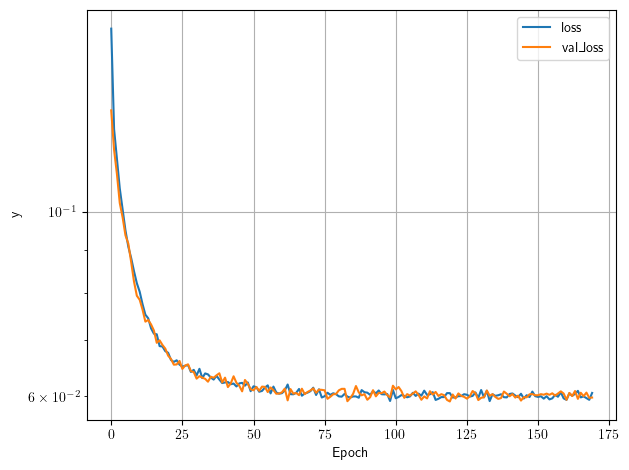

In [ ]:
main(df)